In [1]:
import numpy as np
import progressbar
import matplotlib.pyplot as plt
from waveprop.fresnel import fresnel_conv
fresnel_conv

<function waveprop.fresnel.fresnel_conv(u_in, wv, d1, dz, device=None, dtype=None, d2=None, pad=True)>

(256, 256)

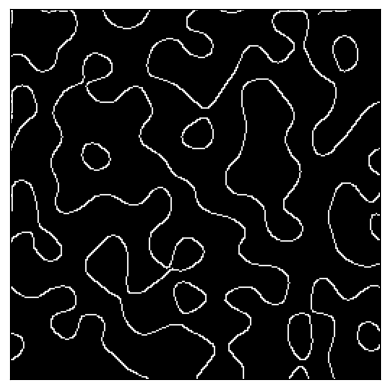

In [12]:
#mask = np.load('../FlatCam/MLS/MLS_6bits.npy')
mask = np.load('../PhlatCam/edges_dim256x256_res8x8.npy')
#mask = np.load('..//FresnelZoneAperture/fza_dim510x255_r30.npy')
plt.imshow(mask, cmap='gray')
_ = plt.xticks([]), plt.yticks([])
mask.shape

In [24]:
def phase_mask_design(target_psf, lambd, d1, dz, n=1.5, n_iter=10):

    M_p = np.sqrt(target_psf)
    for _ in progressbar.ProgressBar()(range(n_iter)):
        M_phi = np.exp(1j * np.angle(fresnel_conv(M_p, lambd, d1, -dz, dtype=np.float32)[0]))
        M_p = np.sqrt(target_psf) * np.exp(1j * fresnel_conv(M_phi, lambd, d1, dz, dtype=np.float32)[0])    
    phi = np.angle(M_phi)

    return phi, lambd * phi / (2 * np.pi * (n-1))


In [25]:
lambd, sensor_size, nb_px, dz = 532e-9, 5e-3, 256, 0.5e-3
d1 = sensor_size / nb_px
phase = phase_mask_design(mask, lambd, d1, dz)

100% |########################################################################|


In [29]:
phase[0].shape

(256, 256)

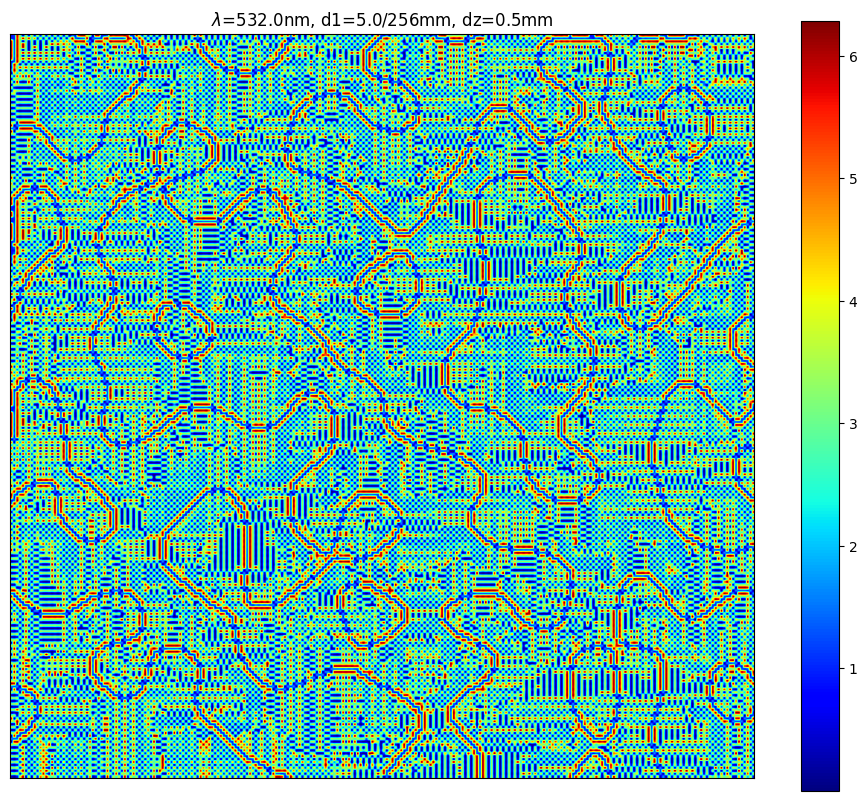

In [26]:
plt.figure(figsize=(12,10))
phase_mask = (phase[0] + 2 * np.pi) % (2 * np.pi)
plt.imshow(phase_mask, cmap='jet')
plt.title(f'$\lambda$={lambd*1e9}nm, d1={sensor_size*1e3}/{nb_px}mm, dz={dz*1e3}mm')
plt.colorbar()
_ = plt.xticks([]), plt.yticks([])

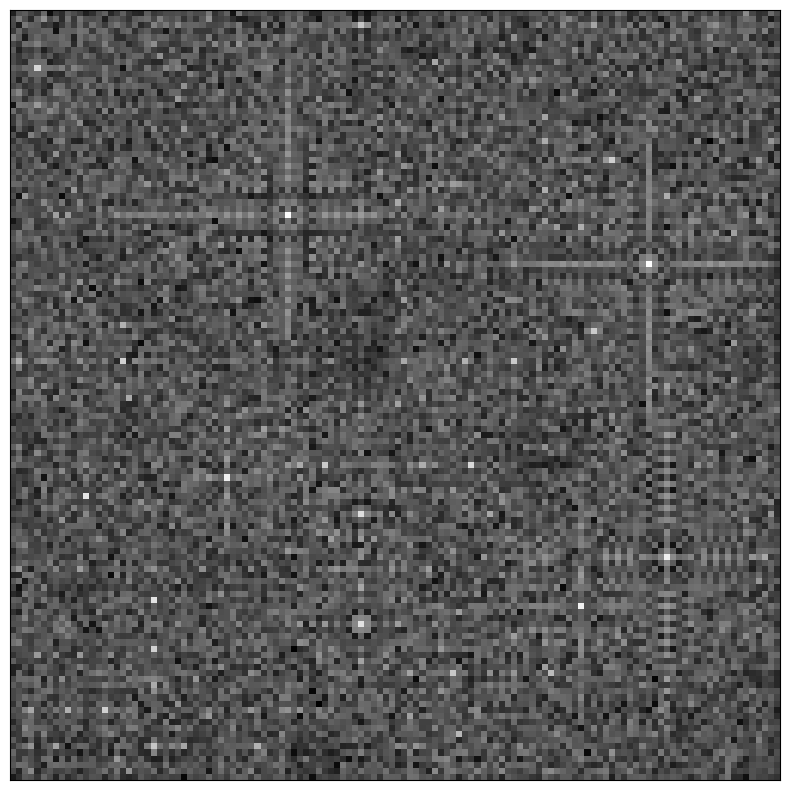

In [7]:
plt.figure(figsize=(10,10))
plt.imshow(np.sqrt(abs(fresnel_conv(phase[0], lambd, d1, dz)[0])), cmap='gray')
_ = plt.xticks([]), plt.yticks([])